### Imports

In [12]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.callbacks import EvalCallback

import matplotlib.pyplot as plt

### Create Env

In [13]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

### Train Env

In [14]:
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])

eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=1000,
                             deterministic=True, render=False)

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=20000)

---------------------------------
| explained_variance | -0.00586 |
| fps                | 13       |
| nupdates           | 1        |
| policy_entropy     | 0.682    |
| total_timesteps    | 5        |
| value_loss         | 6.63     |
---------------------------------
---------------------------------
| explained_variance | -0.00722 |
| fps                | 335      |
| nupdates           | 100      |
| policy_entropy     | 0.687    |
| total_timesteps    | 500      |
| value_loss         | 0.213    |
---------------------------------
---------------------------------
| explained_variance | 0.000389 |
| fps                | 349      |
| nupdates           | 200      |
| policy_entropy     | 0.688    |
| total_timesteps    | 1000     |
| value_loss         | 15.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000268 |
| fps                | 362       |
| nupdates           | 300       |
| policy_entropy     | 0.685     |
| total_t

### Test Env

In [15]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 689.1052060000007, 'total_profit': 0.00046066106012241455, 'position': 0}


### Plot Results

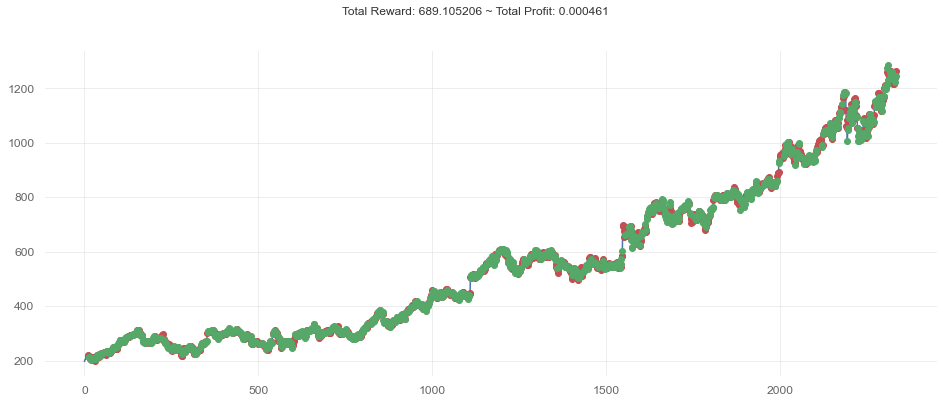

In [16]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -99.95%
CAGR%                      -56.52%

Sharpe                     -4.32
Sortino                    -4.72
Sortino/√2                 -3.34

Max Drawdown               -99.95%
Longest DD Days            3360
Volatility (ann.)          18.83%
Calmar                     -0.57
Skew                       -0.48
Kurtosis                   27.3

Expected Daily %           -0.33%
Expected Monthly %         -6.69%
Expected Yearly %          -53.62%
Kelly Criterion            -81.37%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.27%
Expected Shortfall (cVaR)  -2.27%

Gain/Pain Ratio            -0.82
Gain/Pain (1M)             -0.96

Payoff Ratio               0.83
Profit Factor              0.18
Common Sense Ratio         0.0
CPC Index   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-17,2018-08-15,2018-08-29,3360,-99.954537,-99.950475


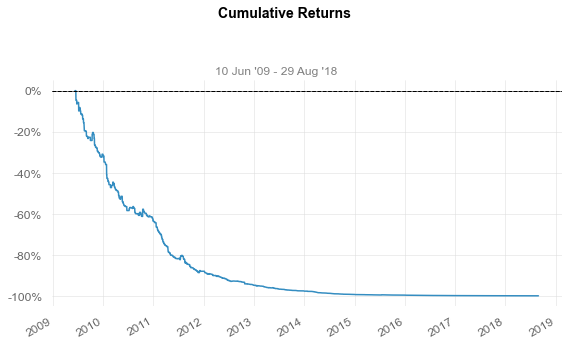

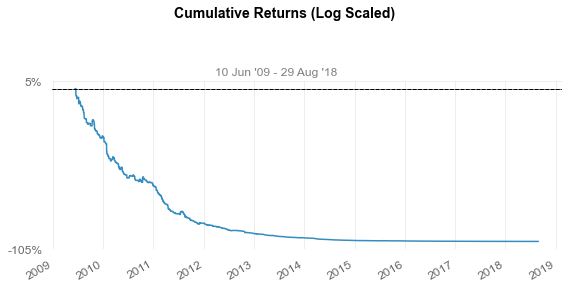

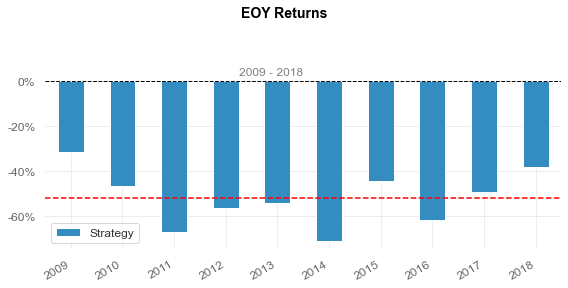

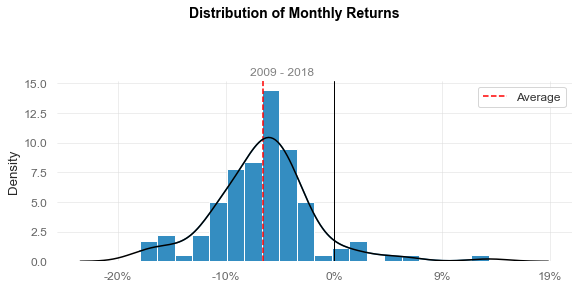

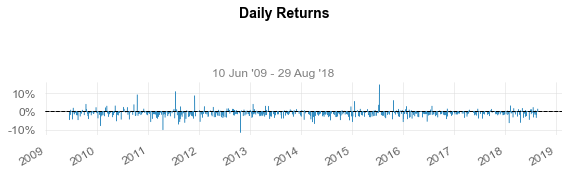

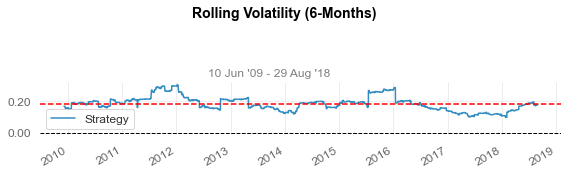

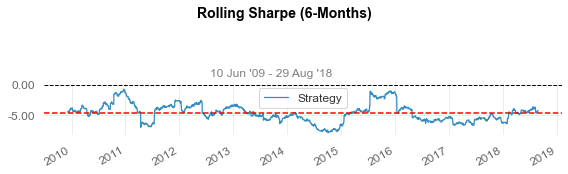

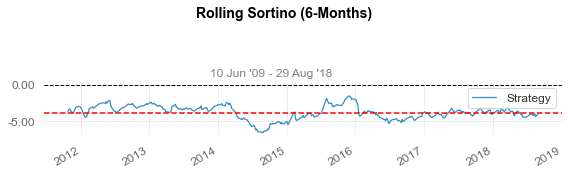

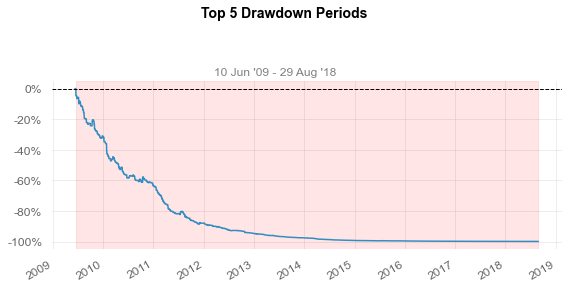

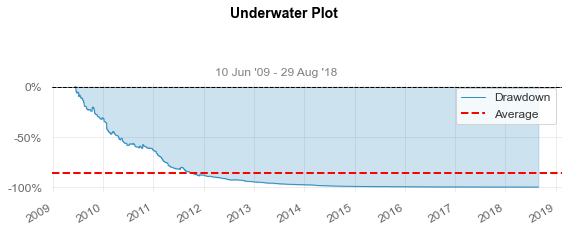

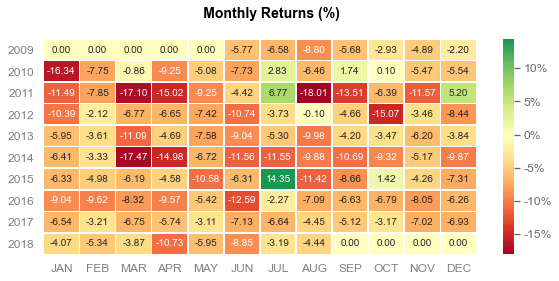

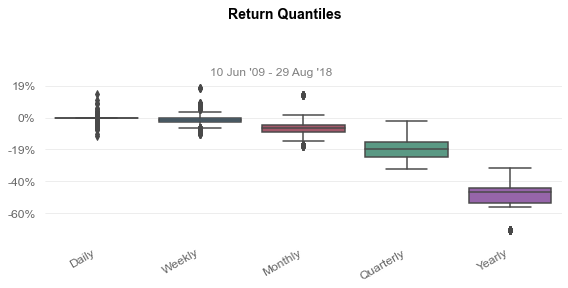

In [17]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')